In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c, h, k_B, M_sun, L_sun
from matplotlib.patches import Rectangle
from tqdm import tqdm
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from lmfit import Model, Parameters
from collections import Counter
from itertools import compress, zip_longest, combinations, chain
from scipy.stats import cumfreq
from functools import partial
utils.rcparams()

In [2]:
herschel = utils.full_loader('Herschel')
vla = utils.full_loader('VLA_COSMOS2020_05')

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

#### Classes and Functions

In [3]:
# Create a set of N random sources
def random_sources(n, ra_min, ra_max, dec_min, dec_max):
    sources_rand = []
    for it in range(n):
        ra_random, dec_random = np.random.uniform(ra_min, ra_max), np.random.uniform(dec_min, dec_max)
        random_source = Source(it, ra_random, dec_random, np.array([0]), np.array([0]), np.array([0]))
        sources_rand.append(random_source)
    return sources_rand

In [1229]:
class Object:

    def __init__(self, name, ra_deg, dec_deg):
        self.id = name
        self.ra = ra_deg
        self.dec = dec_deg


class Source(Object):

    def __init__(self, name, ra, dec, wavelengths_obs_um, fluxes, flux_errors):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.wavelengths_obs_um = wavelengths_obs_um
        self.fluxes = fluxes
        self.flux_errors = flux_errors


class Counterpart(Object):

    def __init__(self, name, ra, dec, fluxes, redshift, stellar_mass):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.fluxes = fluxes
        self.redshift = redshift
        self.stellar_mass = stellar_mass

    @property
    def luminosity_distance(self):
        return cosmo.luminosity_distance(z = self.redshift)

    def number_density(self, counterparts, area):
        return np.sum([counterpart.fluxes > self.fluxes for counterpart in counterparts])/area

    def separation(self, other):
        return np.sqrt(((self.ra - other.ra)**2)+((self.dec - other.dec)**2))*3600

    def s_value(self, source, counterparts, area):
        r = self.separation(source)
        n = self.number_density(counterparts, area)
        s = (r**2)*n
        return s


class Pair:

    def __init__(self, source, counterpart, r, s, p, fit_sed=True):
        self.source = source
        self.counterpart = counterpart
        self.r = r
        self.s = s
        self.p = p

        self.t_cmb = 2.725*(1+self.counterpart.redshift)
        self.source.wavelengths_obs_m = self.source.wavelengths_obs_um*1e-6
        self.source.wavelengths_rest_m = self.source.wavelengths_obs_m/(1+self.counterpart.redshift)
        self.source.nu_rest = c.value/self.source.wavelengths_rest_m

        if fit_sed:

            if np.isnan(self.counterpart.redshift):
                self.log_norm = np.nan
                self.t = np.nan
                self.beta = np.nan
            else:
                mbb_model = Model(mbb)
                params = Parameters()
                params.add_many(('log_norm', -60, True, -65, -55),
                                ('t', 20, True, self.t_cmb, 50),
                                ('beta', 2, True, 1, 4))
                mbb_fit = mbb_model.fit(self.source.fluxes, params, nu_rest=self.source.nu_rest, weights=1/self.source.flux_errors)

                self.log_norm = mbb_fit.params['log_norm'].value
                self.t = mbb_fit.params['t'].value
                self.beta = mbb_fit.params['beta'].value

    def sed(self, nu_rest):
        return mbb(nu_rest, self.log_norm, self.t, self.beta)*u.Jy

    def fir_luminosity(self, lam_um_rest_low=8, lam_um_rest_high=1000):
        lam_low_um_rest, lam_high_um_rest = lam_um_rest_low*u.micron, lam_um_rest_high*u.micron
        wave_range_rest_um = np.linspace(1, 5000, 100000) * u.micron
        wave_range_rest_m = wave_range_rest_um.to(u.m)
        freq_range_rest = c / wave_range_rest_m
        idx = np.where((wave_range_rest_um >= lam_low_um_rest) & (wave_range_rest_um <= lam_high_um_rest))

        diff_freq = np.diff(freq_range_rest)
        diff_freq = np.append(diff_freq, diff_freq[-1])

        sed_obs_integral = self.sed(freq_range_rest[idx].value)
        sed_rest_integral = sed_obs_integral/(1+self.counterpart.redshift)
        integral = np.sum(-sed_rest_integral*diff_freq[idx])

        d_L = cosmo.luminosity_distance(z=self.counterpart.redshift).to(u.m)
        l_watt = (4 * np.pi * (d_L ** 2) * integral).to(u.Watt)
        l_sun = l_watt.to(u.L_sun)
        return l_sun

    def sfr(self):
        # From Murphy+2011
        l_sun = self.fir_luminosity()
        l_cgs = l_sun.to(u.erg/u.s)
        constant = 3.88e-44*(u.M_sun/u.yr)/(u.erg/u.s)
        sfr = constant*l_cgs
        return sfr


class Survey:

    def __init__(self, sources, counterparts):

        # Input sources and counterparts
        self.sources_all = sources
        self.counterparts_all = counterparts
        print('Input Number of Sources = {}'.format(len(self.sources_all)))
        print('Input Number of Counterparts = {}'.format(len(self.counterparts_all)))

        # Define the overlapping survey area
        sources_ra = [self.sources_all[obj].ra for obj in range(len(self.sources_all))]
        sources_dec = [self.sources_all[obj].dec for obj in range(len(self.sources_all))]
        counterparts_ra = [self.counterparts_all[obj].ra for obj in range(len(self.counterparts_all))]
        counterparts_dec = [self.counterparts_all[obj].dec for obj in range(len(self.counterparts_all))]
        self.ra_min, self.ra_max = max(min(sources_ra),min(counterparts_ra)), min(max(sources_ra),max(counterparts_ra))
        self.dec_min, self.dec_max = max(min(sources_dec),min(counterparts_dec)), min(max(sources_dec),max(counterparts_dec))
        self.area_deg = (abs(self.ra_max - self.ra_min)) * (abs(self.dec_max - self.dec_min))
        self.area_arcsec = (np.sqrt(self.area_deg)*3600)**2

        # Reduce sources and counterparts to overlapping region
        self.sources = [obj for obj in self.sources_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        self.counterparts = [obj for obj in self.counterparts_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        print('Overlapping Number of Sources = {} ({:.2f}%)'.format(len(self.sources), (len(self.sources)/len(self.sources_all))*100))
        print('Overlapping Number of Counterparts = {} ({:.2f}%)'.format(len(self.counterparts), (len(self.counterparts)/len(self.counterparts_all))*100))

    # Get random sources
    def get_random_sources(self, n):
        sources_rand = random_sources(n, self.ra_min, self.ra_max, self.dec_min, self.dec_max)
        return sources_rand

    def get_s_values(self, r_max_arcsec, n=100000, random=False, disable=False):
        if random:
            sources = self.get_random_sources(n)
        else:
            sources = self.sources

        min_s_values = []
        for source in tqdm(sources, desc = 'Calculating S Values', disable=disable):
            counterpart_s_values = []
            r_max_deg = r_max_arcsec/3600
            ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
            possible_counterparts = [counterpart for counterpart in self.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
            for counterpart in possible_counterparts:
                r = counterpart.separation(source)
                if r <= r_max_arcsec:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    counterpart_s_values.append(s)
            min_s = min(counterpart_s_values, default=np.nan)
            min_s_values.append(min_s)
        min_s_values_finite = np.array([s for s in min_s_values if np.isfinite(s)])
        min_s_values_finite_sorted = sorted(min_s_values_finite)
        return min_s_values_finite_sorted

    def get_matches(self, r_max_arcsec, n=100000, disable=False):
        d_s_random = self.get_s_values(r_max_arcsec=r_max_arcsec, n=n, random=True, disable=disable)
        pairs = []
        for source in tqdm(self.sources, desc='Calculating P Values', disable=disable):
            r_max_deg = r_max_arcsec/3600
            ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
            possible_counterparts = [counterpart for counterpart in self.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
            for counterpart in possible_counterparts:
                r = counterpart.separation(source)
                if r <= r_max_arcsec:
                    s_i = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    p = len([s for s in d_s_random if s < s_i])/n
                    if p < 1/n:
                        p = 1/n
                    pair = Pair(source, counterpart, r, s_i, p)
                    pairs.append(pair)
        return d_s_random, pairs


class Group:

    def __init__(self, pairs):
        self.pairs = pairs
        self.counterparts = [pair.counterpart for pair in self.pairs]
        self.source = [pair.source for pair in self.pairs]


    @property
    def average_radio_position(self):
        av_ra = np.mean([pair.counterpart.ra for pair in self.pairs])
        av_dec = np.mean([pair.counterpart.dec for pair in self.pairs])
        return av_ra, av_dec

    @property
    def average_counterpart_source_separation(self):
        av_counterpart_ra, av_counterpart_dec = self.average_radio_position
        source_ra, source_dec = self.pairs[0].source.ra, self.pairs[0].source.dec
        separation = np.sqrt(((source_ra - av_counterpart_ra)**2)+((source_dec - av_counterpart_dec)**2))*3600
        return separation

    def counterpart_counterpart_z_difference(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        z_diff = [abs(self.pairs[it[0]].counterpart.redshift - self.pairs[it[1]].counterpart.redshift) for it in index_list]
        return z_diff

    def select_close_counterpart_pairs(self, z_max=0.2):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        z_diff = self.counterpart_counterpart_z_difference()
        close_index = [idx for idx, z in zip(index_list, z_diff) if z <= z_max]
        close_index_flat = list(set([item for sublist in close_index for item in sublist]))
        close_pairs = [self.pairs[idx] for idx in close_index_flat]
        return close_pairs

    def counterpart_source_separations(self):
        separations_arcsec = [pair.r for pair in self.pairs]
        return separations_arcsec

    def counterpart_counterpart_separations(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        separations_arcsec = [self.pairs[it[0]].counterpart.separation(self.pairs[it[1]].counterpart) for it in index_list]
        return separations_arcsec

    def counterpart_counterpart_distance(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        av_z = [(self.pairs[it[0]].counterpart.redshift+self.pairs[it[1]].counterpart.redshift)/2 for it in index_list]
        separations_arcsec = self.counterpart_counterpart_separations()*u.arcsec
        try:
            d_A = cosmo.angular_diameter_distance(av_z)
        except:
            d_A = np.nan*u.Mpc

        distance_kpc = (separations_arcsec*d_A).to(u.kpc, u.dimensionless_angles())
        return distance_kpc

    def counterpart_flux_contribution(self, n_max=3):
        fluxes = sorted([obj.fluxes.item() for obj in self.counterparts], reverse=True)
        total_flux = np.sum(fluxes)
        contribution = fluxes/total_flux
        n = len(contribution)
        return np.pad(contribution, (0,n_max-n), 'constant', constant_values=np.nan)


In [1230]:
def bb(nu, t):
    return (nu**3)*(1/(np.exp((h.value*nu)/(k_B.value*t)) - 1))


def mbb(nu_rest, log_norm, t, beta):
    norm = 10**log_norm
    return norm*(nu_rest**beta)*bb(nu_rest, t)


def create_sources_and_counterparts(source_params, counterpart_params):

    source_catalogue = []
    for obj in tqdm(range(len(source_params['data'])), desc='Creating Sources'):
        name = source_params['data'][source_params['name']][obj]
        ra = source_params['data'][source_params['ra']][obj]
        dec = source_params['data'][source_params['dec']][obj]
        wavelengths_obs_um = source_params['wavelengths_obs_um']
        fluxes = np.array(source_params['data'][source_params['fluxes']].iloc[obj])
        flux_errors = np.array(source_params['data'][source_params['flux_errors']].iloc[obj])
        source = Source(name, ra, dec, wavelengths_obs_um, fluxes, flux_errors)
        source_catalogue.append(source)

    counterpart_catalogue = []
    for obj in tqdm(range(len(counterpart_params['data'])), desc='Creating Counterparts'):
        name = counterpart_params['data'][counterpart_params['name']][obj]
        ra = counterpart_params['data'][counterpart_params['ra']][obj]
        dec = counterpart_params['data'][counterpart_params['dec']][obj]
        fluxes = np.array(counterpart_params['data'][counterpart_params['fluxes']].iloc[obj])
        redshift = counterpart_params['data'][counterpart_params['redshift']][obj]
        stellar_mass = counterpart_params['data'][counterpart_params['stellar_mass']][obj]
        counterpart = Counterpart(name, ra, dec, fluxes, redshift, stellar_mass)
        counterpart_catalogue.append(counterpart)

    return source_catalogue, counterpart_catalogue

#### Create Survey

In [1231]:
source_params = {'data': herschel,
                 'name': 'id_her',
                 'ra': 'RA_her',
                 'dec': 'Dec_her',
                 'wavelengths_obs_um': np.array([250,350,500]),
                 'fluxes': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500'],
                 'flux_errors': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500']}

counterpart_params = {'data': vla,
                      'name': 'id_cos',
                      'ra': 'RA_cos',
                      'dec': 'Dec_cos',
                      'fluxes': ['total_int_flux'],
                      'redshift': 'lp_zPDF',
                      'stellar_mass': 'lp_mass_med'}

In [1232]:
herschel_objects, vla_objects = create_sources_and_counterparts(source_params, counterpart_params)

Creating Counterparts: 100%|██████████| 10830/10830 [00:01<00:00, 9043.13it/s]


In [1233]:
cosmos = Survey(herschel_objects, vla_objects)

Input Number of Sources = 11185
Input Number of Counterparts = 10830
Overlapping Number of Sources = 7230 (64.64%)
Overlapping Number of Counterparts = 10826 (99.96%)


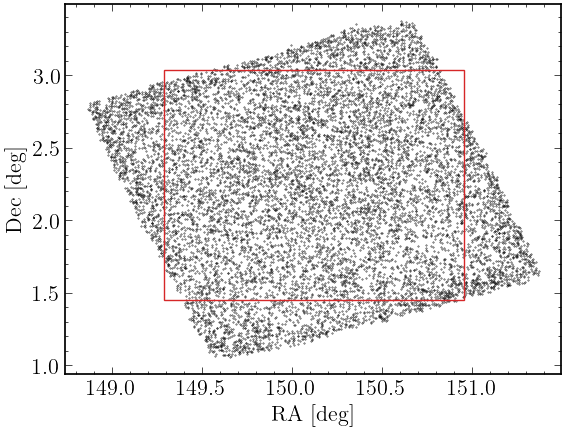

In [1078]:
herschel_ras = [herschel_objects[it].ra for it in range(len(herschel_objects))]
herschel_decs = [herschel_objects[it].dec for it in range(len(herschel_objects))]

fig, ax = plt.subplots()
ax.scatter(herschel_ras, herschel_decs, s=0.1)
ax.add_patch(Rectangle((cosmos.ra_min, cosmos.dec_min), cosmos.ra_max-cosmos.ra_min, cosmos.dec_max-cosmos.dec_min, edgecolor='tab:red', facecolor='none'))
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'Dec [deg]')
plt.savefig(utils.ROOT+'/figures/sky_map.pdf', dpi=1000)
plt.show()

#### Optimal Search Radius

In [131]:
N = len(cosmos.sources)
r_max_arcsec = 30

rand_sources = random_sources(N, cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max)

rand_r = []
rand_f = []
herschel_r = []
herschel_f = []

for source in tqdm(rand_sources, desc='Random Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        f = counterpart.fluxes.item()
        if r <= r_max_arcsec:
            rand_r.append(r)
            rand_f.append(f)

for source in tqdm(cosmos.sources, desc='Herschel Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        f = counterpart.fluxes.item()
        if r <= r_max_arcsec:
            herschel_r.append(r)
            herschel_f.append(f)

rand_r_hist, bin_edges = np.histogram(rand_r, bins=30, range=(0,30))
herschel_r_hist, _ = np.histogram(herschel_r, bins=30, range=(0,30))
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

rand_r_cum = cumfreq(rand_r, 30, defaultreallimits=(0,30))
herschel_r_cum = cumfreq(herschel_r, 30, defaultreallimits=(0,30))

rand_r_freq = np.array(rand_r_cum.cumcount)
herschel_r_freq = np.array(herschel_r_cum.cumcount)

Herschel Sources: 100%|██████████| 7230/7230 [00:04<00:00, 1714.00it/s]


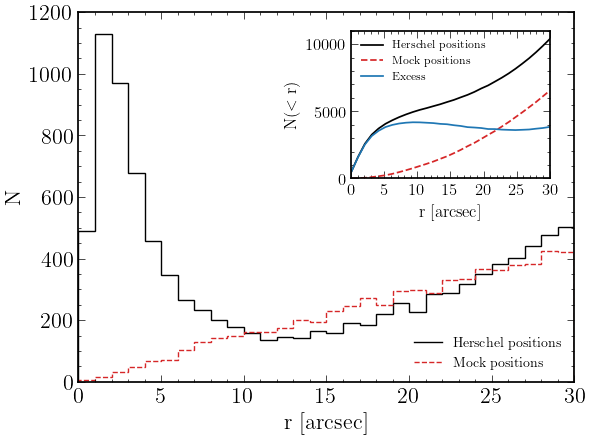

In [293]:
r_range = np.linspace(0,30,30)

fig, ax = plt.subplots()
ax.stairs(herschel_r_hist, bin_edges, label=r'Herschel positions')
ax.stairs(rand_r_hist, bin_edges, linestyle='--', label=r'Mock positions')

axin = ax.inset_axes([0.55,0.55,0.4,0.4])
axin.plot(r_range, herschel_r_freq, label=r'Herschel positions')
axin.plot(r_range, rand_r_freq, linestyle='--', label=r'Mock positions')
axin.plot(r_range, herschel_r_freq-rand_r_freq, label=r'Excess')
axin.set_xlabel(r'r [arcsec]', fontsize=12)
axin.set_ylabel(r'N($<$ r)', fontsize=12)
axin.tick_params(axis='both', labelsize=12)
axin.set_xticks([0,5,10,15,20,25,30])
axin.set_xlim(0,30)
axin.set_ylim(0,11000)
axin.legend(fontsize=8)

ax.set_xlim(0,30)
ax.set_ylim(0,1200)
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.legend(loc='lower right', fontsize=10)
plt.savefig(utils.ROOT+'/figures/optimal_radius.pdf', dpi=1000)
plt.show()

Expected maximum P based on Poisson statistics:
Let X be the number of VLA sources observed within a single search radius

$$\lambda = N_{\textrm{VLA}}A_{\textrm{Circle}}/A_{\textrm{Survey}}$$

\begin{align}
    P_{\textrm{max}} &\sim \frac{P(\textrm{Not-blank})}{P(\textrm{Blank})} \\
    &= \frac{P(X > 0)}{P(X = 0)} \\
    &= \frac{1-P(X = 0)}{P(X = 0)} \\
    &= \frac{1-e^{-\lambda}}{e^{-\lambda}}
\end{align}

In [236]:
# Expected maximum P value (ignoring overlapping regions and assuming Poisson statistics)

r_max = 10
N_vla = len(cosmos.counterparts)
a_circle = np.pi*(r_max**2)
a_survey = cosmos.area_arcsec
lam = (N_vla*a_circle)/a_survey
prob_max = (1-np.exp(-lam))/(np.exp(-lam))
print('The number density of VLA objects = {:.2f} per square degree'.format(N_vla/cosmos.area_deg))
print('The maximum probability is expected to be approximately = {:.2f}'.format(prob_max))

The number density of VLA objects = 4103.01 per square degree
The maximum probability is expected to be approximately = 0.10


#### D(S) Distributions and Robust Sample

In [239]:
r_max = 10
herschel_ds = cosmos.get_s_values(r_max_arcsec=r_max)
random_ds, herschel_vla = cosmos.get_matches(r_max, n=1000000)

Calculating P Values: 100%|██████████| 7230/7230 [00:49<00:00, 144.88it/s]


/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_35064/1186990355.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.hist(np.log10(random_ds), bins=250, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)


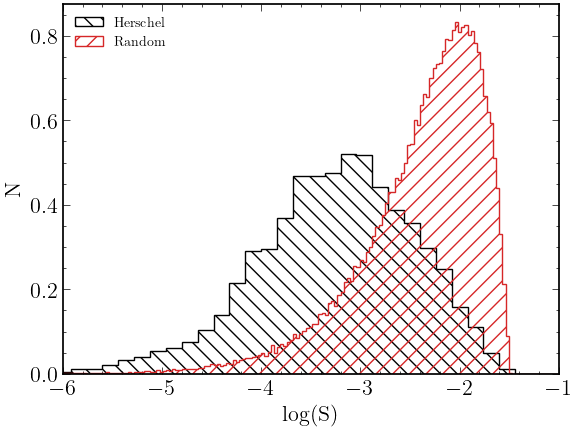

In [294]:
logs_range = (-8,0)

fig, ax = plt.subplots()
ax.hist(np.log10(herschel_ds), bins=50, range=logs_range, histtype='step', hatch=r'\\', label=r'Herschel', density=True)
ax.hist(np.log10(random_ds), bins=250, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)
ax.set_xlabel(r'log(S)')
ax.set_ylabel(r'N')
ax.set_xlim(-6,-1)
ax.legend(fontsize=10, loc='upper left')
plt.savefig(utils.ROOT+'/figures/ds_distributions.pdf', dpi=1000)
plt.show()

In [1234]:
def create_groups(p_max, pairs):
    robust = [pair for pair in pairs if pair.p <= p_max]
    robust_ids, _ = np.unique([pair.source.id for pair in robust], return_counts=True)
    robust_sorted = sorted(robust, key = lambda pair: (pair.source.id, pair.p))
    robust_lists = [[pair for i, pair in enumerate(robust_sorted) if pair.source.id == idx] for idx in robust_ids]
    robust_array = np.array(list(zip_longest(*robust_lists, fillvalue=np.nan))).T

    try:
        primaries_list = [[pairs[0]] for pairs in robust_array if ~pd.isna([pairs[0]])]
        primaries_group = [Group(pairs) for pairs in primaries_list]
    except:
        primaries_group = []
        print('No Primary Objects')

    try:
        secondaries_list = [[pairs[1]] for pairs in robust_array if ~pd.isna([pairs[1]])]
        secondaries_group = [Group(pairs) for pairs in secondaries_list]
    except:
        secondaries_group = []
        print('No Secondary Objects')

    try:
        tertiaries_list = [[pairs[2]] for pairs in robust_array if ~pd.isna([pairs[2]])]
        tertiaries_group = [Group(pairs) for pairs in tertiaries_list]
    except:
        tertiaries_group = []
        print('No Tertiary Objects')

    robust_singles = robust_array[pd.isna(robust_array[:, 1])][:,0]
    robust_multiples = robust_array[~pd.isna(robust_array[:, 1])]

    robust_singles_list = [[pair] for pair in robust_singles if ~pd.isna([pair])]
    robust_multiples_list = [robust_multiples[it][~pd.isnull(robust_multiples[it])].tolist() for it in range(len(robust_multiples))]

    robust_singles_group = [Group(pairs) for pairs in robust_singles_list]
    robust_multiples_group = [Group(pairs) for pairs in robust_multiples_list]

    groups = {'primaries': primaries_group,
              'secondaries': secondaries_group,
              'tertiaries': tertiaries_group,
              'singles': robust_singles_group,
              'multiples': robust_multiples_group}

    return groups

In [1235]:
flux_limit = 0.03
p_max = 0.05

herschel_vla_flux = [obj for obj in herschel_vla if obj.source.fluxes[0] > flux_limit]

groups = create_groups(p_max, herschel_vla)
groups_flux = create_groups(p_max, herschel_vla_flux)

#### Important Statistics

In [756]:
n_sources = len(cosmos.sources)
n_counterparts = len(cosmos.counterparts)
n_sources_flux = len([source for source in cosmos.sources if source.fluxes[0] > flux_limit])

n_ids = len(groups['primaries'])
n_ids_flux = len(groups_flux['primaries'])

n_false = np.sum([groups.pairs[0].p for groups in groups['primaries']])
n_false_flux = np.sum([groups.pairs[0].p for groups in groups_flux['primaries']])

print('The number of Herschel sources = {}'.format(n_sources))
print('The number of VLA sources = {}'.format(n_counterparts))
print('The number of sources with IDs = {} ({:.2f}%)'.format(n_ids, (n_ids/n_sources)*100))
print('The number of false IDs to sources = {:.2f} ({:.2f}%)'.format(n_false, (n_false/n_sources)*100))

print('The number of Herschel sources > {} mJy = {}'.format(flux_limit*1000, n_sources_flux))
print('The number of sources > {} mJy with IDs = {} ({:.2f}%)'.format(flux_limit*1000, n_ids_flux, (n_ids_flux/n_sources_flux)*100))
print('The number of false IDs to sources > {} mJy = {:.2f} ({:.2f}%)'.format(flux_limit*1000, n_false_flux, (n_false_flux/n_sources_flux)*100))

The number of Herschel sources = 7230
The number of VLA sources = 10826
The number of sources with IDs = 3787 (52.38%)
The number of false IDs to sources = 47.75 (0.66%)
The number of Herschel sources > 30.0 mJy = 1324
The number of sources > 30.0 mJy with IDs = 1053 (79.53%)
The number of false IDs to sources > 30.0 mJy = 6.71 (0.51%)


In [757]:
counter_flux = Counter([len(obj.pairs) for obj in groups_flux['singles']])+Counter([len(obj.pairs) for obj in groups_flux['multiples']])
print('The number of IDs per source > {} mJy: {}'.format(flux_limit*1000, counter_flux))

The number of IDs per source > 30.0 mJy: Counter({1: 879, 2: 160, 3: 14})


In [758]:
print('The average number of potential counterparts to each source = {:.2f}'.format(len(cosmos.counterparts)/len(cosmos.sources)))

The average number of potential counterparts to each source = 1.50


#### ID Fraction

In [380]:
flux_range = np.logspace(-2.5, 0, 30)

all_fluxes, bin_edges = np.histogram([obj.fluxes[0] for obj in cosmos.sources], bins=flux_range)
primaries_fluxes = [obj.pairs[0].source.fluxes[0] for obj in groups['primaries']]
singles_fluxes = [obj.pairs[0].source.fluxes[0] for obj in groups['singles']]
multiples_fluxes = [obj.pairs[0].source.fluxes[0] for obj in groups['multiples']]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

primaries_fluxes_id = np.histogram(primaries_fluxes, bins=flux_range)[0]/all_fluxes
primaries_fluxes_id_err = np.sqrt(np.histogram(primaries_fluxes, bins=flux_range)[0])/all_fluxes
singles_fluxes_id = np.histogram(singles_fluxes, bins=flux_range)[0]/all_fluxes
multiples_fluxes_id = np.histogram(multiples_fluxes, bins=flux_range)[0]/all_fluxes

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_35064/663277299.py:9: RuntimeWarning: invalid value encountered in divide
  primaries_fluxes_id = np.histogram(primaries_fluxes, bins=flux_range)[0]/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_35064/663277299.py:10: RuntimeWarning: invalid value encountered in divide
  primaries_fluxes_id_err = np.sqrt(np.histogram(primaries_fluxes, bins=flux_range)[0])/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_35064/663277299.py:11: RuntimeWarning: invalid value encountered in divide
  singles_fluxes_id = np.histogram(singles_fluxes, bins=flux_range)[0]/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_35064/663277299.py:12: RuntimeWarning: invalid value encountered in divide
  multiples_fluxes_id = np.histogram(multiples_fluxes, bins=flux_range)[0]/all_fluxes


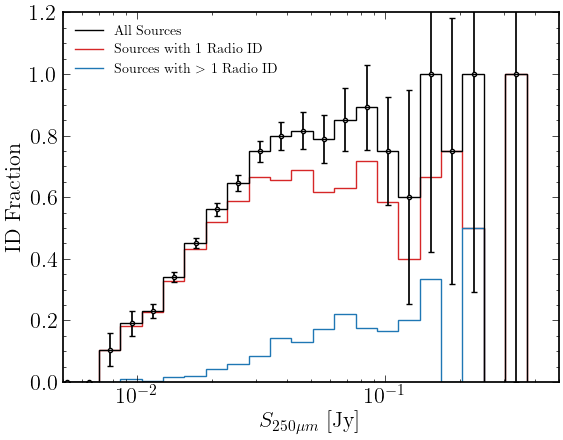

In [615]:
fig, ax = plt.subplots()
ax.stairs(primaries_fluxes_id, flux_range, label=r'All Sources', zorder=10)
ax.errorbar(bin_centers, primaries_fluxes_id, yerr=primaries_fluxes_id_err, fmt='.', c='k')
ax.stairs(singles_fluxes_id, flux_range, label=r'Sources with 1 Radio ID')
ax.stairs(multiples_fluxes_id, flux_range, label=r'Sources with $>$ 1 Radio ID')
ax.set_xlabel(r'$S_{250\mu m}$ [Jy]')
ax.set_ylabel(r'ID Fraction')
ax.set_xlim(5e-3,5e-1)
ax.set_ylim(0,1.2)
ax.semilogx()
ax.legend(loc='upper left', fontsize=10)
plt.savefig(utils.ROOT+'/figures/id_fraction_radio.pdf', dpi=1000)
plt.show()

#### Source-Counterpart Offsets

In [654]:
primaries_sc_offset = list(chain.from_iterable([obj.counterpart_source_separations() for obj in groups_flux['primaries']]))
secondaries_sc_offset = list(chain.from_iterable([obj.counterpart_source_separations() for obj in groups_flux['secondaries']]))
tertiaries_sc_offset = list(chain.from_iterable([obj.counterpart_source_separations() for obj in groups_flux['tertiaries']]))

In [655]:
singles_sc_offset_average = [group.average_counterpart_source_separation for group in groups_flux['singles']]
multiples_sc_offset_average = [group.average_counterpart_source_separation for group in groups_flux['multiples']]
all_sc_offset_average = singles_sc_offset_average+multiples_sc_offset_average
all_sc_offset = primaries_sc_offset+secondaries_sc_offset+tertiaries_sc_offset

In [656]:
primaries_sc_hist, r_bins = np.histogram(primaries_sc_offset, bins=20, range=(0,10))
primaries_sc_hist_err = np.sqrt(primaries_sc_hist)
all_average_sc_hist, _ = np.histogram(all_sc_offset_average, bins=20, range=(0,10))
all_sc_hist, _ = np.histogram(all_sc_offset, bins=20, range=(0,10))
r_bin_centers = (r_bins[:-1] + r_bins[1:])/2

In [657]:
def rayleigh(r, A, sigma):
    return A*(r/(sigma**2))*(np.exp(-(r**2)/(2*(sigma**2))))

# Create a model for our radial offset distribution
rmodel = Model(rayleigh)
params = rmodel.make_params(A=500, sigma=2)
params['A'].vary = True
params['sigma'].vary = True
result = rmodel.fit(primaries_sc_hist, params, r=r_bin_centers, weights=1/primaries_sc_hist_err)

# Determine the best fitting values of parameters
A_best = result.params['A'].value
sigma_best = result.params['sigma'].value

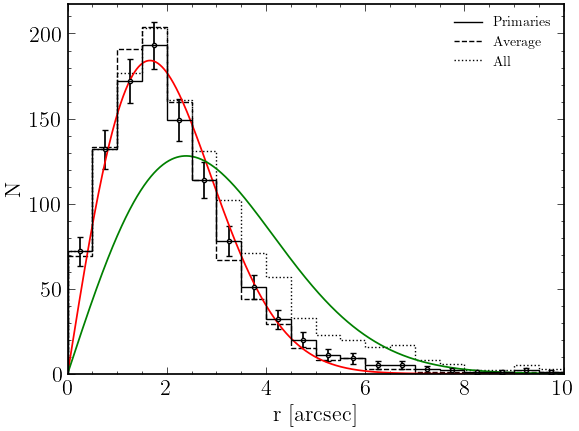

In [700]:
r_range = np.linspace(0,10,1000)

fig, ax = plt.subplots()
ax.stairs(primaries_sc_hist, r_bins, label='Primaries', zorder=10)
ax.errorbar(r_bin_centers, primaries_sc_hist, yerr=primaries_sc_hist_err, fmt='.', c='k')
ax.stairs(all_average_sc_hist, r_bins, color='k', linestyle='--',  label='Average')
ax.stairs(all_sc_hist, r_bins, color='k', linestyle=':',  label='All')
ax.plot(r_range, rayleigh(r_range, A_best, sigma_best), c='r')
ax.plot(r_range, rayleigh(r_range, A_best, 2.388), c='g')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,10)
ax.legend(fontsize=10)
plt.show()

#### Multiples

In [1241]:
source_fluxes = np.log10([group.source[0].fluxes[0] for group in groups['multiples']])
flux_contributions = [group.counterpart_flux_contribution() for group in groups['multiples']]
first_contribution = [list_[0] for list_ in flux_contributions]
second_contribution = [list_[1] for list_ in flux_contributions]
third_contribution = [list_[2] for list_ in flux_contributions]

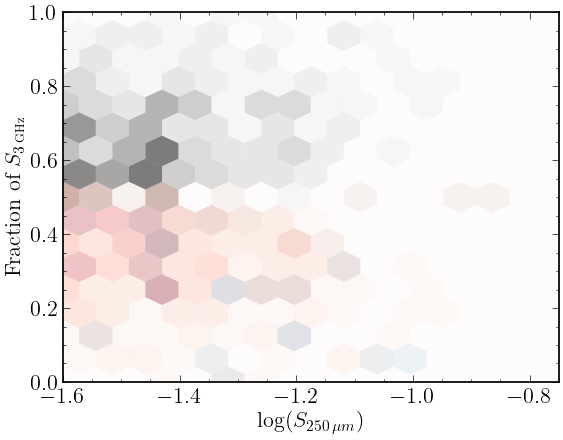

In [1242]:
fig, ax = plt.subplots()
ax.hexbin(source_fluxes, third_contribution, cmap='Blues', edgecolors='None', alpha=0.5, extent=(-1.6,-0.75,0,1), gridsize=15, label=r'Radio Brightest')
ax.hexbin(source_fluxes, second_contribution, cmap='Reds', edgecolors='None', alpha=0.5, extent=(-1.6,-0.75,0,1), gridsize=15, label=r'Second Brightest')
ax.hexbin(source_fluxes, first_contribution, cmap='Greys', edgecolors='None', alpha=0.5, extent=(-1.6,-0.75,0,1), gridsize=15, label=r'Third Brightest')
ax.set_xlabel(r'log($S_{\small 250\,\mu m}$)')
ax.set_ylabel(r'Fraction of $S_{\small 3\,\textrm{GHz}}$')
ax.set_xlim(-1.6,-0.75)
ax.set_ylim(0,1)
plt.show()

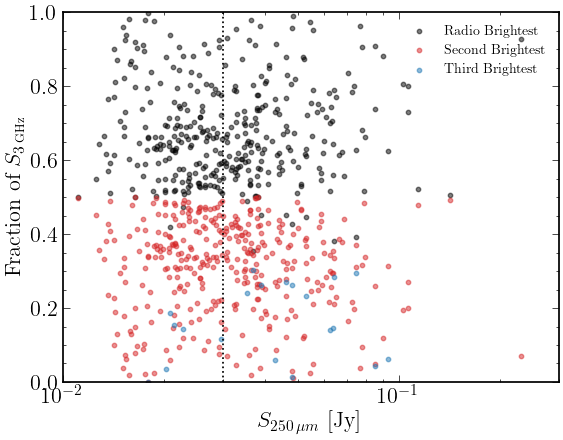

In [1257]:
source_fluxes = [group.source[0].fluxes[0] for group in groups['multiples']]

fig, ax = plt.subplots()
ax.scatter(source_fluxes, first_contribution, alpha=0.5, s=10, label=r'Radio Brightest')
ax.scatter(source_fluxes, second_contribution, alpha=0.5, s=10, label=r'Second Brightest')
ax.scatter(source_fluxes, third_contribution, alpha=0.5, s=10, label=r'Third Brightest')
ax.axvline(30/1000, linestyle=':')
ax.set_xlabel(r'$S_{\small 250\,\mu m}$ [Jy]')
ax.set_ylabel(r'Fraction of $S_{\small 3\,\textrm{GHz}}$')
ax.set_xlim(1e-2, 3e-1)
ax.set_ylim(0,1)
ax.semilogx()
ax.legend(fontsize=10)
plt.show()

In [1084]:
close_multiples_list = [obj.select_close_counterpart_pairs(z_max=0.2) for obj in groups_flux['multiples']]
close_multiples = [Group(pairs) for pairs in close_multiples_list]
groups_flux['close_multiples'] = close_multiples

In [1086]:
multiples_cc_zdiff = list(chain.from_iterable([obj.counterpart_counterpart_z_difference() for obj in groups_flux['multiples']]))

multiples_cc_offsets = list(chain.from_iterable([obj.counterpart_counterpart_separations() for obj in groups_flux['multiples']]))
close_multiples_cc_offsets = list(chain.from_iterable([obj.counterpart_counterpart_separations() for obj in groups_flux['close_multiples']]))

In [1132]:
def separation_to_distance(r, z):
    r = r*u.arcsec
    d_A = cosmo.angular_diameter_distance(z)
    distance_kpc = (r*d_A).to(u.kpc, u.dimensionless_angles())
    return distance_kpc.value

def distance_to_separation(d, z):
    d = d*u.kpc
    d_A = cosmo.angular_diameter_distance(z)
    r = (d/d_A).to(u.arcsec, u.dimensionless_angles())
    return r.value

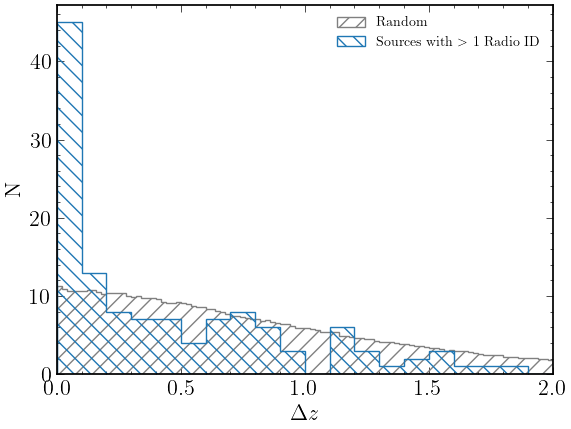

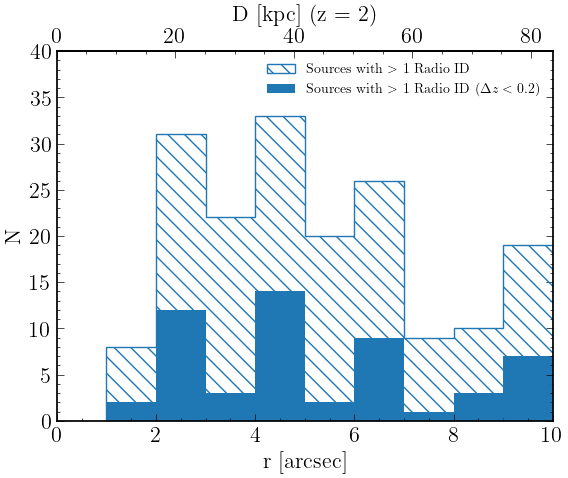

In [1174]:
n_z_bins = 20
n_z_bins_random = 100
z_range = (0,2)

N = 1000000
random_z_differences = []

for _ in range(N):
    rand_obj_1, rand_obj_2 = random.sample(vla_objects, 2)
    rand_z_diff = abs(rand_obj_1.redshift - rand_obj_2.redshift)
    if rand_z_diff > 0:
        random_z_differences.append(rand_z_diff)

weights_z = np.full_like(random_z_differences, (n_z_bins_random/n_z_bins)*(len(multiples_cc_zdiff)/N))

fig, ax = plt.subplots()
ax.hist(random_z_differences, bins=n_z_bins_random, range=z_range, histtype='step', hatch=r'//', color='grey', label=r'Random', weights=weights_z)
ax.hist(multiples_cc_zdiff, bins=n_z_bins, range=z_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Sources with $>$ 1 Radio ID')
ax.set_xlabel(r'$\Delta z$')
ax.set_ylabel(r'N')
ax.set_xlim(0,2)
ax.legend(fontsize=10)
plt.show()

n_r_bins = 10
r_range = (0,10)

fig, ax = plt.subplots()
ax.hist(multiples_cc_offsets, bins=n_r_bins, range=r_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Sources with $>$ 1 Radio ID')
ax.hist(close_multiples_cc_offsets, bins=n_r_bins, range=r_range, histtype='stepfilled', color='tab:blue', label=r'Sources with $>$ 1 Radio ID ($\Delta z < 0.2$)')

ax.tick_params(axis='x', which='both', top=False)
secax = ax.secondary_xaxis('top', functions=(partial(separation_to_distance, z=2), partial(distance_to_separation, z=2)))
secax.set_xlabel(r'D [kpc] (z = 2)')

ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,10)
ax.set_ylim(0,40)
ax.legend(fontsize=10)
plt.show()

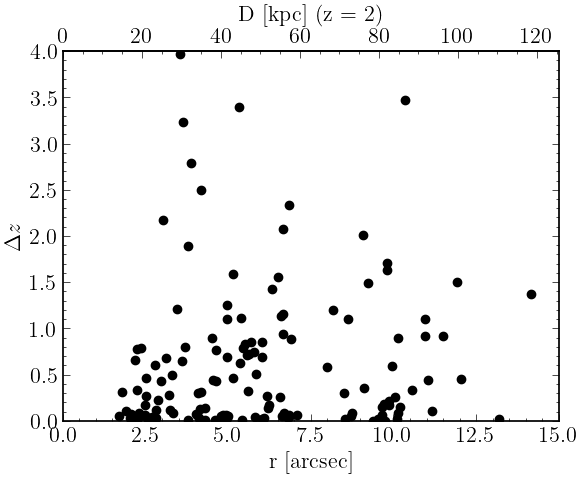

In [1219]:
fig, ax = plt.subplots()
ax.scatter(multiples_cc_offsets, multiples_cc_zdiff)

ax.tick_params(axis='x', which='both', top=False)
secax = ax.secondary_xaxis('top', functions=(partial(separation_to_distance, z=2), partial(distance_to_separation, z=2)))
secax.set_xlabel(r'D [kpc] (z = 2)')

ax.set_xlim(0,15)
ax.set_ylim(0,4)
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'$\Delta z$')
plt.show()

#### Testing

In [299]:
from astropy.io import fits
from astropy.wcs import WCS

In [275]:
hdul = fits.open("/Users/bradleyward/Downloads/0001_150.60840000_2.85890000_sdss_r_matched-psf_110_sci_20.fits")

In [301]:
wcs = WCS(hdul[0].header)

In [287]:
image_data = hdul[0].data

In [366]:
source_id = groups_flux['multiples'][9].pairs[0].source.id
source_ra, source_dec = wcs.wcs_world2pix(groups_flux['multiples'][9].pairs[0].source.ra, groups_flux['multiples'][9].pairs[0].source.dec, 1)

counterpart1_ra, counterpart1_dec = wcs.wcs_world2pix(groups_flux['multiples'][9].pairs[0].counterpart.ra, groups_flux['multiples'][9].pairs[0].counterpart.dec, 1)
counterpart2_ra, counterpart2_dec = wcs.wcs_world2pix(groups_flux['multiples'][9].pairs[1].counterpart.ra, groups_flux['multiples'][9].pairs[1].counterpart.dec, 1)
counterpart3_ra, counterpart3_dec = wcs.wcs_world2pix(groups_flux['multiples'][9].pairs[2].counterpart.ra, groups_flux['multiples'][9].pairs[2].counterpart.dec, 1)

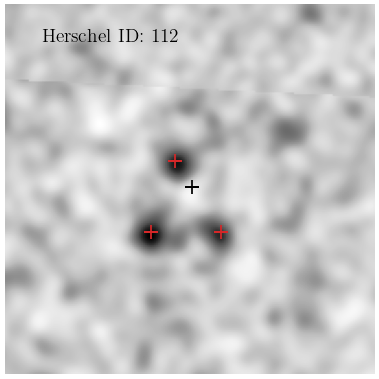

In [702]:
ax = plt.subplot(projection=wcs)
ra = ax.coords[0]
dec = ax.coords[1]
ra.set_format_unit('deg')
dec.set_format_unit('deg')
ax.imshow(image_data, cmap='Greys')
ax.text(0.1, 0.9, 'Herschel ID: '+str(source_id), transform=ax.transAxes, fontsize=14)
ax.scatter(source_ra, source_dec, marker='+', s=100, c='k')
ax.scatter(counterpart1_ra, counterpart1_dec, marker='+', s=100, c='tab:red')
ax.scatter(counterpart2_ra, counterpart2_dec, marker='+', s=100, c='tab:red')
ax.scatter(counterpart3_ra, counterpart3_dec, marker='+', s=100, c='tab:red')
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'Dec [deg]')
plt.axis('off')
plt.show()